### Import libraries

In [1]:
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# import own modules
sys.path.append(
    os.path.join("..", "..")
)  # Adds higher directory to python modules path.
from scripts import preprocessing as pp
from scripts import evaluate_models as em

# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
)

---
## Preparations

### Load the CSV into a Dataframe

- load csv (or calculate again if not in data folder)
- update index=id
- drop useless columns
- find numerical & object columns

In [2]:
# path to csv file
path_df = os.path.join("..", "..", "data", "df_deep_sam.csv")

# get features
df = pd.read_csv(path_df)

# set id as index
df = df.set_index("id", drop=True)

# drop first batch of useless variables
df = df.drop(columns=["img", "sp_idx"])
df = df.drop(columns=[col for col in df.columns if "_obj" in col])
df = df.drop(columns=[col for col in df.columns if "dg_sal_" in col])

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7598 instances and 34 columns
 -> there are 34 numerical columns
 -> there are 0 categoricals columns


### First, drop instances & features

- unusual long fixation durations are identified as outliers and dropped
  - drop if "dur > 5000 ms"
- drop `sal_first_above_0.75*max_rank` & `sal_first_above_0.9*max_rank` since this features consists of mainly (33% / 61%) outlier values
  - outliers are coded as "20" 


In [3]:
# processing
df = df[df["sp_fix_duration_ms_total"] <= 5000]
df = df.drop(columns=["sam_sal_first_above_0.75*max_rank", "sam_sal_first_above_0.9*max_rank"])

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7217 instances and 32 columns
 -> there are 32 numerical columns
 -> there are 0 categoricals columns


### Checking for highly correlated columns
think after running this lines, which column to additionally drop

Correlation between sam_sal_mean and sam_sal_NSS is 0.85
Correlation between obj_n_fix_face and obj_t_abs_on_face is 0.822
Correlation between obj_n_fix_face and obj_t_rel_on_face is 0.801
Correlation between obj_n_fix_inanimate and obj_t_abs_on_inanimate is 0.868
Correlation between obj_n_fix_inanimate and obj_t_rel_on_inanimate is 0.841
Correlation between obj_n_fix_background and obj_t_abs_on_background is 0.84
Correlation between obj_n_fix_background and obj_t_rel_on_background is 0.804


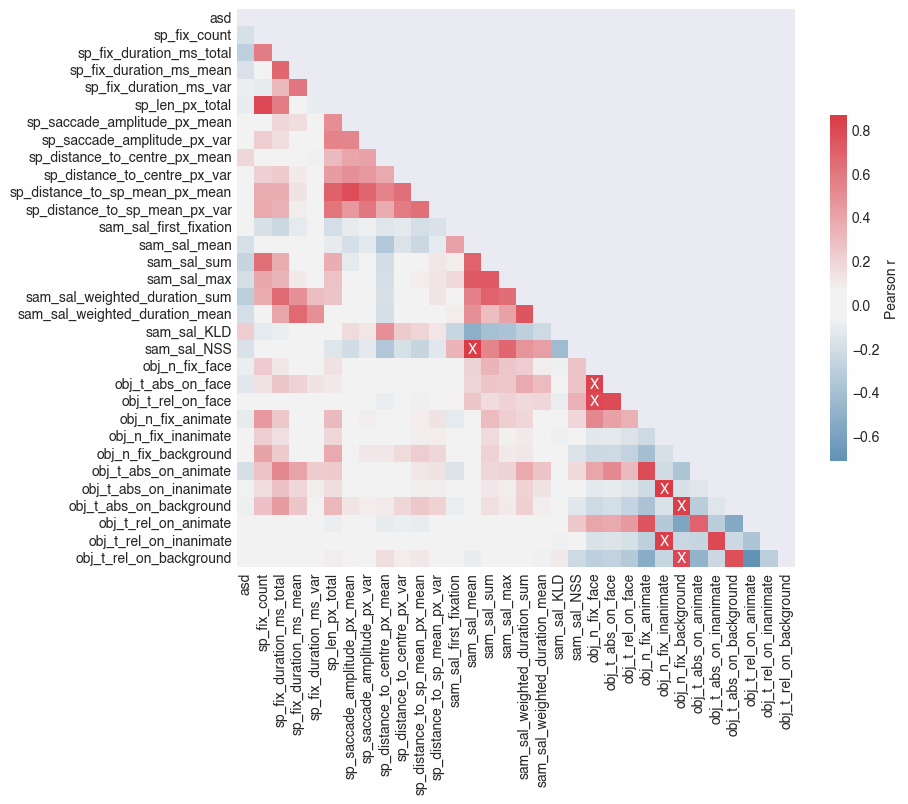

In [4]:
# check for correlations
pp.check_correlations(df[num_cols], thresh=0.8)

### further processing of correlating features
- `sp_fix_duration_ms_total` & `sp_fix_duration_ms_mean`
  - keep the `saliency weighted` version of both fixation duration measures
- `obj_n_fix_*`
  - keep the time measures of object recognition features

Correlation between sam_sal_mean and sam_sal_NSS is 0.85


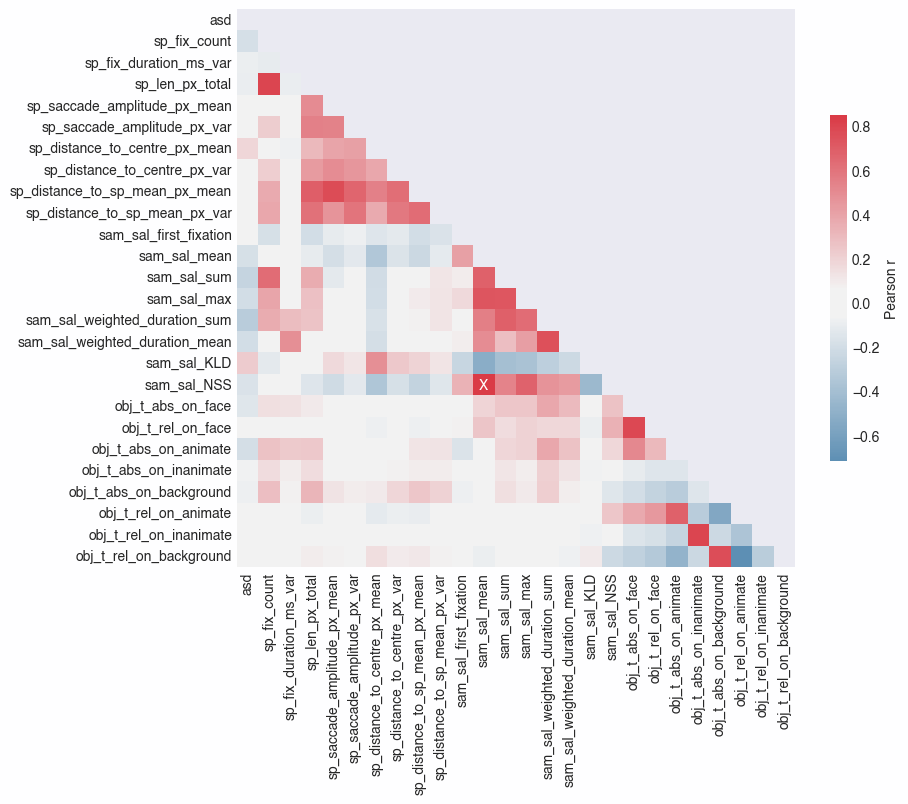

 -> dataframe has 7217 instances and 26 columns
 -> there are 26 numerical columns
 -> there are 0 categoricals columns


In [5]:
# processing
df = df.drop(
    columns=[
        "sp_fix_duration_ms_total",
        "sp_fix_duration_ms_mean",
        "obj_n_fix_face",
        "obj_n_fix_animate",
        "obj_n_fix_inanimate",
        "obj_n_fix_background",
    ]
)

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# check for correlations, again
pp.check_correlations(df[num_cols], thresh=0.8)

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

### Split into train & test sets

As soon as the dataset is in its final form, perform train-test-split with our own split function to have out 30-image-set always as our test set.

In [6]:
# prepare features and target
X = df
y = X.pop("asd")

# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

# print info
print(f"train-set has '{len(y_train)}' samples & '{X.shape[1]}' features")
print(f"test-set has '{len(y_test)}' samples - out of '{df.shape[0]}'")
print(f"  ~ {len(y_test) / df.shape[0] * 100:.2f}% of full dataset")

train-set has '6485' samples & '25' features
test-set has '732' samples - out of '7217'
  ~ 10.14% of full dataset


### Set variables

- define `metric`
- behavior for saving models as pickles
- defaults for model-objects

In [7]:
# metric
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# model_folder
default_mdl_folder = os.path.join("..", "..", "models", "dev", "RF_Grid_sam")

# defaults
RSEED = 42
cv = 10
n_jobs = -1
verbose = 1

---
## Model - Preparations

###  Pipelines for each Model

In [8]:
# Random Forest: no scaling / no encoding
rf_pipeline = Pipeline([("classifier", RandomForestClassifier())])

---
## Modeling

### Random Forest

#### 1: Full Grid

In [9]:
# grid
param_grid_rf = {
    "classifier__max_depth": [5, 10, 20, 30, 50],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [1, 2, 5, 10, 20],
    "classifier__min_samples_split": [2, 5, 10, 20, 50, 100],
    "classifier__n_estimators": [100, 200, 300, 400],
}

# Create GridSearchCV object & fit it
grid_search_rf_v1 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v1_full.pickle"

# fit or load
grid_search_rf_v1 = em.fit_or_load(
    grid_search_rf_v1, X_train, y_train, model_name, folder=default_mdl_folder
)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
 -> model saved in: '../../models/dev/RF_Grid_sam/RF_grid_v1_full.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.928     0.925     0.926      3252
           1      0.925     0.928     0.926      3233

    accuracy                          0.926      6485
   macro avg      0.926     0.926     0.926      6485
weighted avg      0.926     0.926     0.926      6485

f(0.5)-score: 0.925
f(2.0)-score: 0.927

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.687     0.722     0.704       371
           1      0.699     0.662     0.680       361

    accuracy                          0.693       732
   macro avg      0.693     0.692     0.692       732
weighted avg      0.693     0.693     0.692       732

f(0.5)-score: 0.691
f(2.0)-score: 0.669



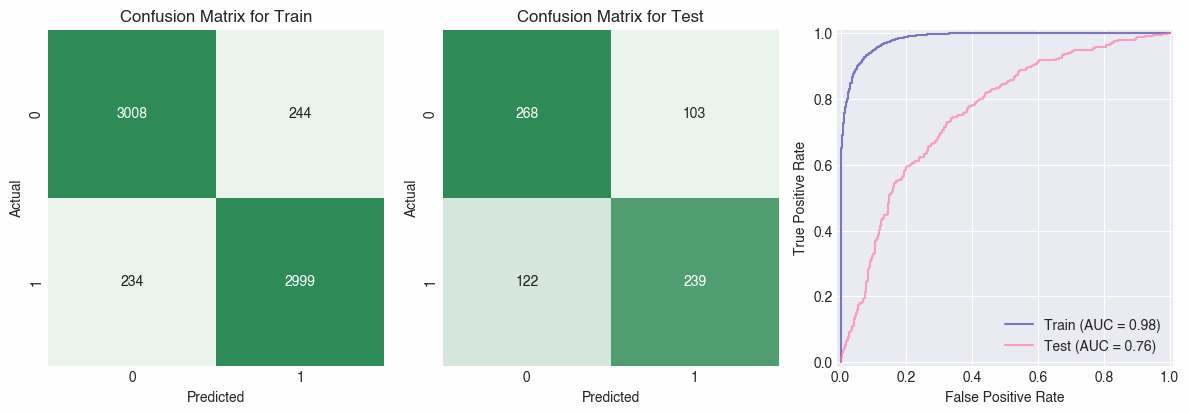

In [10]:
# predict & proba
pred_test = grid_search_rf_v1.predict(X_test)
proba_test = grid_search_rf_v1.predict_proba(X_test)

pred_train = grid_search_rf_v1.predict(X_train)
proba_train = grid_search_rf_v1.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [11]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v1)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=50, min_samples_split=20,
                                        n_estimators=300))])

 ----- best parameter: -----
{'classifier__max_depth': 50,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 20,
 'classifier__n_estimators': 300}

 ----- RandomForestClassifier -----
   has on average 829 nodes
   has on average a maximum depth of 23



---

#### 2: prune "max_depth" & "min_sample_leafs"

In [12]:
# grid
param_grid_rf = {
    "classifier__max_depth": [5, 10, 20],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [5, 10, 20],
    "classifier__min_samples_split": [5, 10, 20, 50],
    "classifier__n_estimators": [200, 300, 400],
}

# Create GridSearchCV object & fit it
grid_search_rf_v2 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v2_pruning.pickle"

# fit or load
grid_search_rf_v2 = em.fit_or_load(
    grid_search_rf_v2, X_train, y_train, model_name, folder=default_mdl_folder
)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
 -> model saved in: '../../models/dev/RF_Grid_sam/RF_grid_v2_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.930     0.934     0.932      3252
           1      0.933     0.929     0.931      3233

    accuracy                          0.932      6485
   macro avg      0.932     0.932     0.932      6485
weighted avg      0.932     0.932     0.932      6485

f(0.5)-score: 0.932
f(2.0)-score: 0.930

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.680     0.728     0.703       371
           1      0.699     0.648     0.672       361

    accuracy                          0.689       732
   macro avg      0.689     0.688     0.688       732
weighted avg      0.689     0.689     0.688       732

f(0.5)-score: 0.688
f(2.0)-score: 0.658



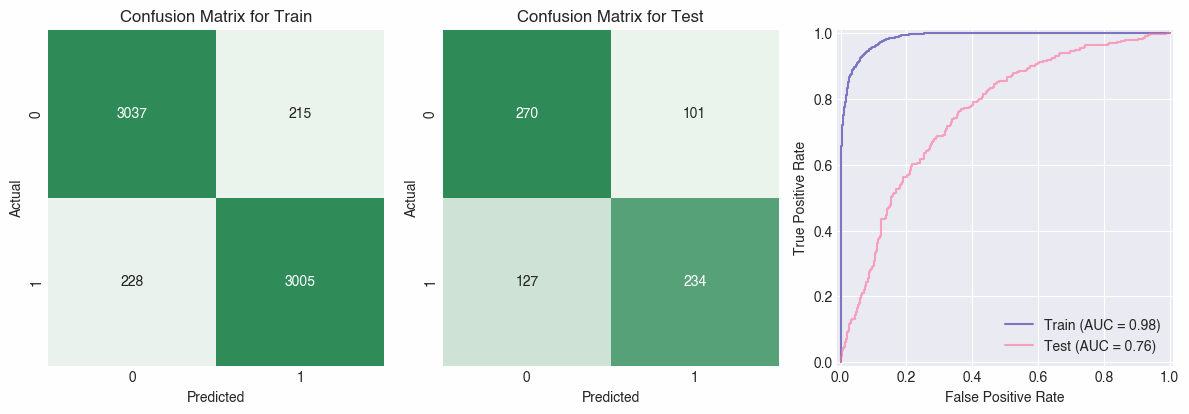

In [13]:
# predict & proba
pred_test = grid_search_rf_v2.predict(X_test)
proba_test = grid_search_rf_v2.predict_proba(X_test)

pred_train = grid_search_rf_v2.predict(X_train)
proba_train = grid_search_rf_v2.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [14]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v2)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=5,
                                        min_samples_split=5,
                                        n_estimators=400))])

 ----- best parameter: -----
{'classifier__max_depth': 20,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 5,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 400}

 ----- RandomForestClassifier -----
   has on average 1043 nodes
   has on average a maximum depth of 19



---

#### 3: pruning "min_samples_split" & "max_depth"

In [15]:
# grid
param_grid_rf = {
    "classifier__max_depth": [5, 10, 15],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [10, 15, 20],
    "classifier__min_samples_split": [10, 20, 30],
    "classifier__n_estimators": [200, 300, 400],
}

# Create GridSearchCV object & fit it
grid_search_rf_v3 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v3_pruning.pickle"

# fit or load
grid_search_rf_v3 = em.fit_or_load(
    grid_search_rf_v3, X_train, y_train, model_name, folder=default_mdl_folder
)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
 -> model saved in: '../../models/dev/RF_Grid_sam/RF_grid_v3_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.834     0.850     0.842      3252
           1      0.846     0.830     0.838      3233

    accuracy                          0.840      6485
   macro avg      0.840     0.840     0.840      6485
weighted avg      0.840     0.840     0.840      6485

f(0.5)-score: 0.843
f(2.0)-score: 0.833

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.680     0.728     0.703       371
           1      0.699     0.648     0.672       361

    accuracy                          0.689       732
   macro avg      0.689     0.688     0.688       732
weighted avg      0.689     0.689     0.688       732

f(0.5)-score: 0.688
f(2.0)-score: 0.658



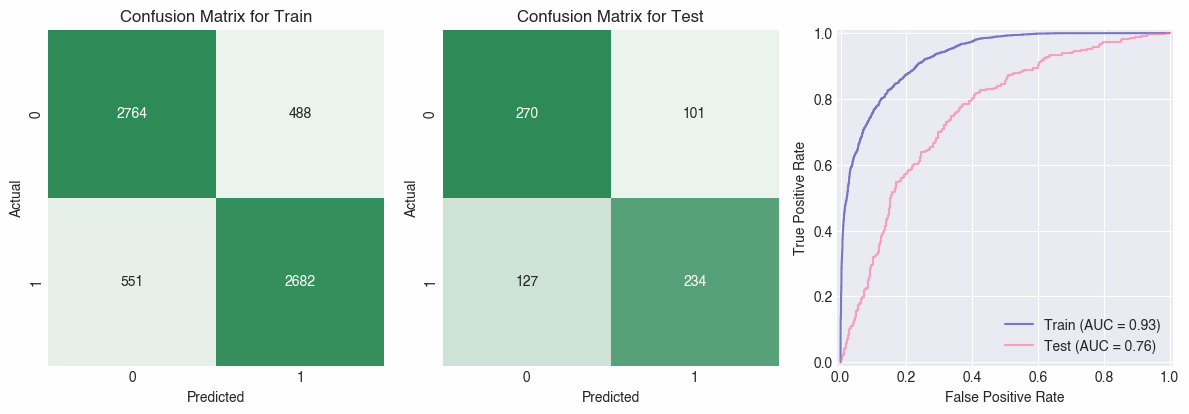

In [16]:
# predict & proba
pred_test = grid_search_rf_v3.predict(X_test)
proba_test = grid_search_rf_v3.predict_proba(X_test)

pred_train = grid_search_rf_v3.predict(X_train)
proba_train = grid_search_rf_v3.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [17]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v3)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=15, min_samples_leaf=10,
                                        min_samples_split=10,
                                        n_estimators=200))])

 ----- best parameter: -----
{'classifier__max_depth': 15,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 10,
 'classifier__min_samples_split': 10,
 'classifier__n_estimators': 200}

 ----- RandomForestClassifier -----
   has on average 569 nodes
   has on average a maximum depth of 15



---

#### 4: more pruning: "max_depth" & "min_samples_leaf" & "min_samples_split"

In [18]:
# grid
param_grid_rf = {
    "classifier__max_depth": [8, 10, 12],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [15, 20],
    "classifier__min_samples_split": [20, 30, 40],
    "classifier__n_estimators": [300, 400, 500],
}

# Create GridSeardchCV object & fit it
grid_search_rf_v4 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v4_pruning.pickle"

# fit or load
grid_search_rf_v4 = em.fit_or_load(
    grid_search_rf_v4, X_train, y_train, model_name, folder=default_mdl_folder
)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
 -> model saved in: '../../models/dev/RF_Grid_sam/RF_grid_v4_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.763     0.782     0.772      3252
           1      0.775     0.755     0.765      3233

    accuracy                          0.769      6485
   macro avg      0.769     0.769     0.769      6485
weighted avg      0.769     0.769     0.769      6485

f(0.5)-score: 0.771
f(2.0)-score: 0.759

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.689     0.741     0.714       371
           1      0.712     0.657     0.683       361

    accuracy                          0.699       732
   macro avg      0.700     0.699     0.699       732
weighted avg      0.700     0.699     0.699       732

f(0.5)-score: 0.700
f(2.0)-score: 0.667



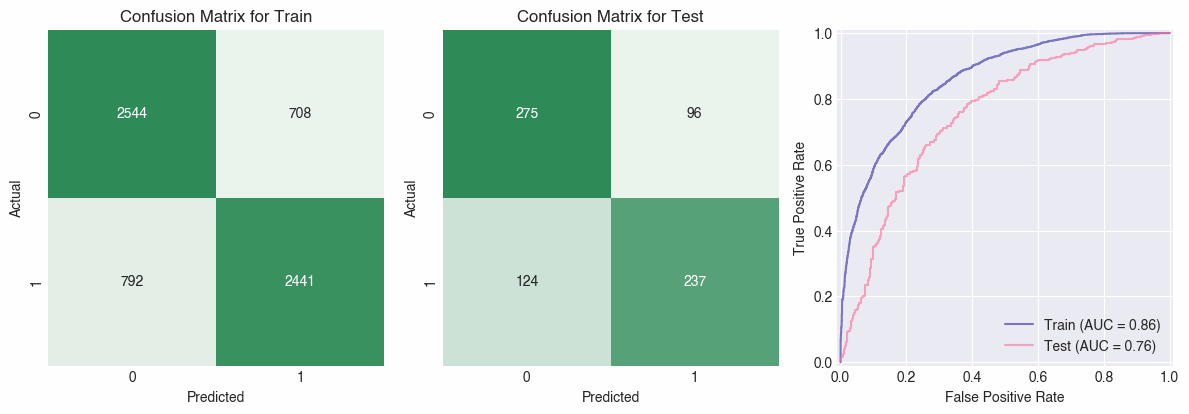

In [19]:
# predict & proba
pred_test = grid_search_rf_v4.predict(X_test)
proba_test = grid_search_rf_v4.predict_proba(X_test)

pred_train = grid_search_rf_v4.predict(X_train)
proba_train = grid_search_rf_v4.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [20]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v4)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=12, min_samples_leaf=20,
                                        min_samples_split=30,
                                        n_estimators=300))])

 ----- best parameter: -----
{'classifier__max_depth': 12,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 20,
 'classifier__min_samples_split': 30,
 'classifier__n_estimators': 300}

 ----- RandomForestClassifier -----
   has on average 286 nodes
   has on average a maximum depth of 12



---

#### 5: finetuning I

In [21]:
# grid
param_grid_rf = {
    "classifier__max_depth": [8, 9, 10],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [18, 22],
    "classifier__min_samples_split": [25, 30, 35],
    "classifier__n_estimators": [300, 400, 500],
}

# Create GridSeardchCV object & fit it
grid_search_rf_v5 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v5_pruning.pickle"

# fit or load
grid_search_rf_v5 = em.fit_or_load(
    grid_search_rf_v5, X_train, y_train, model_name, folder=default_mdl_folder
)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
 -> model saved in: '../../models/dev/RF_Grid_sam/RF_grid_v5_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.754     0.781     0.767      3252
           1      0.772     0.744     0.757      3233

    accuracy                          0.763      6485
   macro avg      0.763     0.762     0.762      6485
weighted avg      0.763     0.763     0.762      6485

f(0.5)-score: 0.766
f(2.0)-score: 0.749

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.696     0.752     0.723       371
           1      0.722     0.662     0.691       361

    accuracy                          0.708       732
   macro avg      0.709     0.707     0.707       732
weighted avg      0.709     0.708     0.707       732

f(0.5)-score: 0.709
f(2.0)-score: 0.673



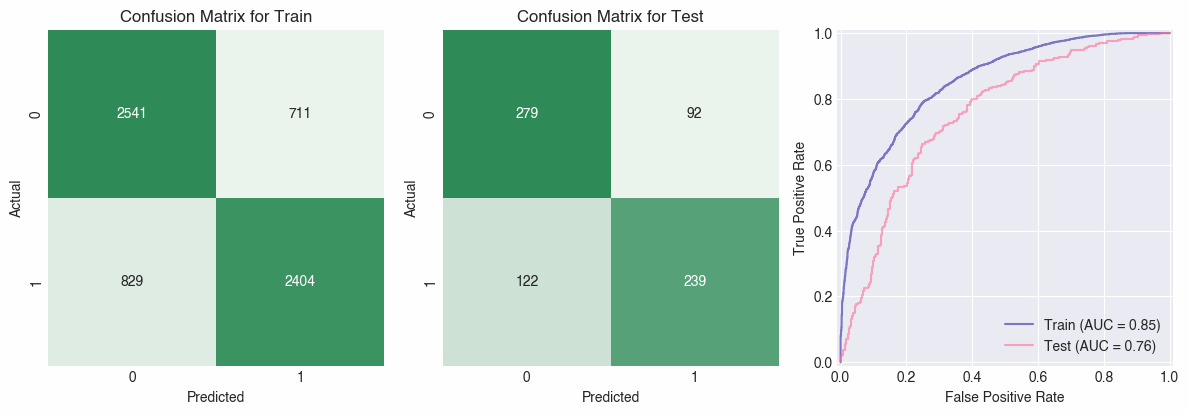

In [22]:
# predict & proba
pred_test = grid_search_rf_v5.predict(X_test)
proba_test = grid_search_rf_v5.predict_proba(X_test)

pred_train = grid_search_rf_v5.predict(X_train)
proba_train = grid_search_rf_v5.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [23]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v5)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=18,
                                        min_samples_split=35,
                                        n_estimators=300))])

 ----- best parameter: -----
{'classifier__max_depth': 10,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 18,
 'classifier__min_samples_split': 35,
 'classifier__n_estimators': 300}

 ----- RandomForestClassifier -----
   has on average 261 nodes
   has on average a maximum depth of 10



---

#### 6: finetuning II

In [24]:
# grid
param_grid_rf = {
    "classifier__max_depth": [8, 9],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [20, 22],
    "classifier__min_samples_split": [25, 30, 35],
    "classifier__n_estimators": [300, 400, 500],
}

# Create GridSeardchCV object & fit it
grid_search_rf_v6 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v6_pruning.pickle"

# fit or load
grid_search_rf_v6 = em.fit_or_load(
    grid_search_rf_v6, X_train, y_train, model_name, folder=default_mdl_folder
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
 -> model saved in: '../../models/dev/RF_Grid_sam/RF_grid_v6_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.734     0.769     0.751      3252
           1      0.756     0.720     0.738      3233

    accuracy                          0.745      6485
   macro avg      0.745     0.745     0.745      6485
weighted avg      0.745     0.745     0.745      6485

f(0.5)-score: 0.749
f(2.0)-score: 0.727

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.677     0.739     0.706       371
           1      0.703     0.637     0.669       361

    accuracy                          0.689       732
   macro avg      0.690     0.688     0.687       732
weighted avg      0.690     0.689     0.688       732

f(0.5)-score: 0.689
f(2.0)-score: 0.649



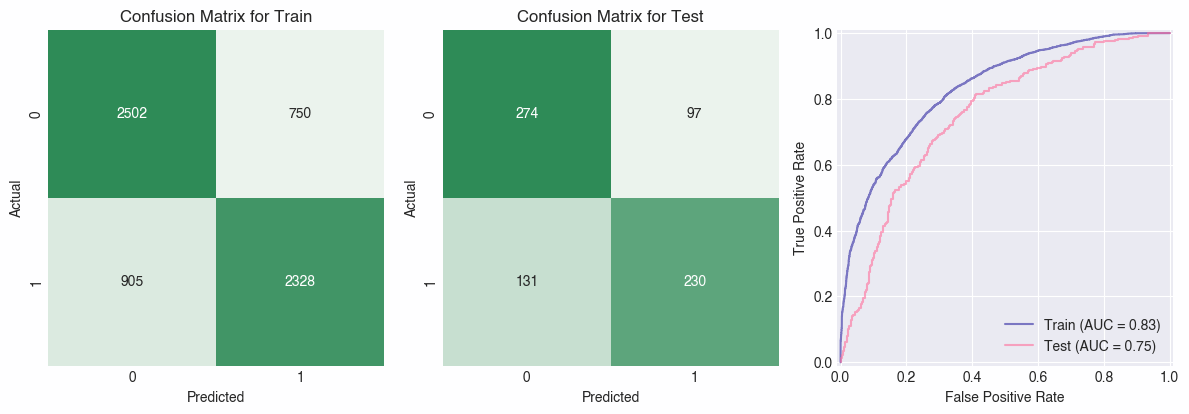

In [25]:
# predict & proba
pred_test = grid_search_rf_v6.predict(X_test)
proba_test = grid_search_rf_v6.predict_proba(X_test)

pred_train = grid_search_rf_v6.predict(X_train)
proba_train = grid_search_rf_v6.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [26]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v6)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=9, min_samples_leaf=22,
                                        min_samples_split=30,
                                        n_estimators=400))])

 ----- best parameter: -----
{'classifier__max_depth': 9,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 22,
 'classifier__min_samples_split': 30,
 'classifier__n_estimators': 400}

 ----- RandomForestClassifier -----
   has on average 197 nodes
   has on average a maximum depth of 9



---

#### 7: finetuning III

In [27]:
# grid
param_grid_rf = {
    "classifier__max_depth": [7, 8],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [20, 22],
    "classifier__min_samples_split": [25, 30, 35],
    "classifier__n_estimators": [200, 300, 400],
}

# Create GridSeardchCV object & fit it
grid_search_rf_v7 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v7_pruning.pickle"

# fit or load
grid_search_rf_v7 = em.fit_or_load(
    grid_search_rf_v7, X_train, y_train, model_name, folder=default_mdl_folder
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
 -> model saved in: '../../models/dev/RF_Grid_sam/RF_grid_v7_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.724     0.762     0.743      3252
           1      0.747     0.708     0.727      3233

    accuracy                          0.735      6485
   macro avg      0.736     0.735     0.735      6485
weighted avg      0.736     0.735     0.735      6485

f(0.5)-score: 0.739
f(2.0)-score: 0.716

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.682     0.752     0.715       371
           1      0.715     0.640     0.675       361

    accuracy                          0.697       732
   macro avg      0.699     0.696     0.695       732
weighted avg      0.698     0.697     0.696       732

f(0.5)-score: 0.699
f(2.0)-score: 0.654



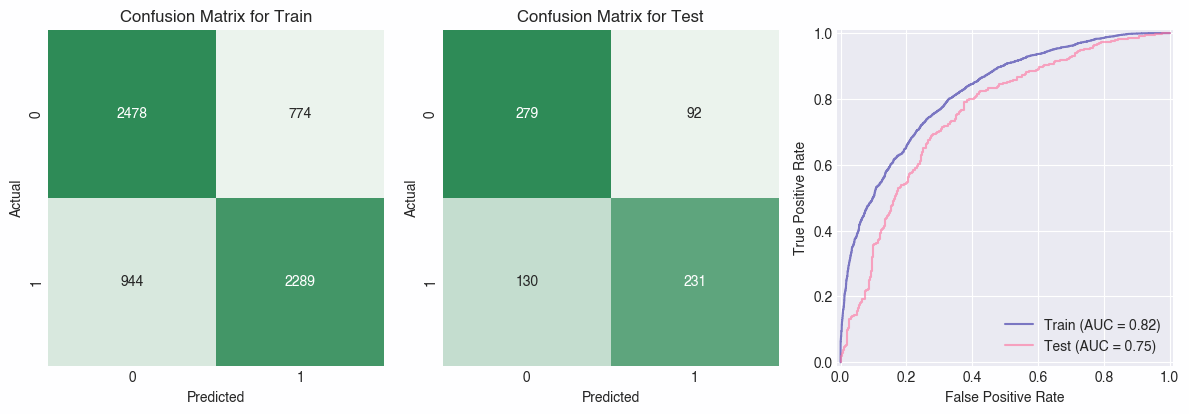

In [28]:
# predict & proba
pred_test = grid_search_rf_v7.predict(X_test)
proba_test = grid_search_rf_v7.predict_proba(X_test)

pred_train = grid_search_rf_v7.predict(X_train)
proba_train = grid_search_rf_v7.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [29]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v7)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=8, min_samples_leaf=20,
                                        min_samples_split=35,
                                        n_estimators=200))])

 ----- best parameter: -----
{'classifier__max_depth': 8,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 20,
 'classifier__min_samples_split': 35,
 'classifier__n_estimators': 200}

 ----- RandomForestClassifier -----
   has on average 170 nodes
   has on average a maximum depth of 8



---

#### 8: finetuning IV

In [30]:
# grid
param_grid_rf = {
    "classifier__max_depth": [7],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [22, 24],
    "classifier__min_samples_split": [33, 36, 39],
    "classifier__n_estimators": [200, 300, 400],
}

# Create GridSeardchCV object & fit it
grid_search_rf_v8 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v8_pruning.pickle"

# fit or load
grid_search_rf_v8 = em.fit_or_load(
    grid_search_rf_v8, X_train, y_train, model_name, folder=default_mdl_folder
)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
 -> model saved in: '../../models/dev/RF_Grid_sam/RF_grid_v8_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.708     0.755     0.731      3252
           1      0.736     0.687     0.711      3233

    accuracy                          0.721      6485
   macro avg      0.722     0.721     0.721      6485
weighted avg      0.722     0.721     0.721      6485

f(0.5)-score: 0.726
f(2.0)-score: 0.696

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.676     0.741     0.707       371
           1      0.705     0.634     0.668       361

    accuracy                          0.689       732
   macro avg      0.690     0.688     0.687       732
weighted avg      0.690     0.689     0.688       732

f(0.5)-score: 0.689
f(2.0)-score: 0.647



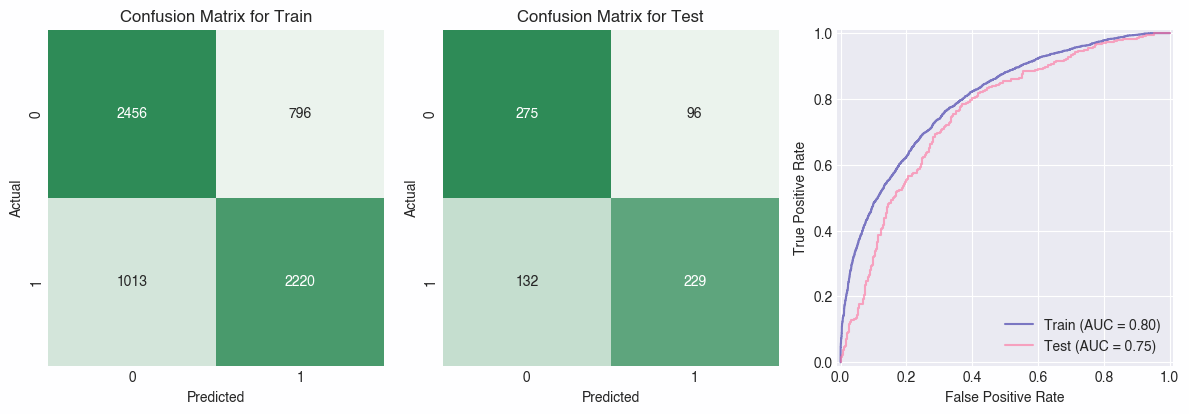

In [31]:
# predict & proba
pred_test = grid_search_rf_v8.predict(X_test)
proba_test = grid_search_rf_v8.predict_proba(X_test)

pred_train = grid_search_rf_v8.predict(X_train)
proba_train = grid_search_rf_v8.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [32]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v8)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=7, min_samples_leaf=24,
                                        min_samples_split=39,
                                        n_estimators=200))])

 ----- best parameter: -----
{'classifier__max_depth': 7,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 24,
 'classifier__min_samples_split': 39,
 'classifier__n_estimators': 200}

 ----- RandomForestClassifier -----
   has on average 121 nodes
   has on average a maximum depth of 7



---

#### 9: finetuning V

In [33]:
# grid
param_grid_rf = {
    "classifier__max_depth": [6],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [26],
    "classifier__min_samples_split": [33, 36],
    "classifier__n_estimators": [150, 200, 300],
}

# Create GridSeardchCV object & fit it
grid_search_rf_v9 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v9_pruning.pickle"

# fit or load
grid_search_rf_v9 = em.fit_or_load(
    grid_search_rf_v9, X_train, y_train, model_name, folder=default_mdl_folder
)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
 -> model saved in: '../../models/dev/RF_Grid_sam/RF_grid_v9_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.686     0.745     0.715      3252
           1      0.719     0.658     0.687      3233

    accuracy                          0.701      6485
   macro avg      0.703     0.701     0.701      6485
weighted avg      0.703     0.701     0.701      6485

f(0.5)-score: 0.706
f(2.0)-score: 0.669

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.670     0.739     0.703       371
           1      0.700     0.626     0.661       361

    accuracy                          0.683       732
   macro avg      0.685     0.682     0.682       732
weighted avg      0.685     0.683     0.682       732

f(0.5)-score: 0.684
f(2.0)-score: 0.640



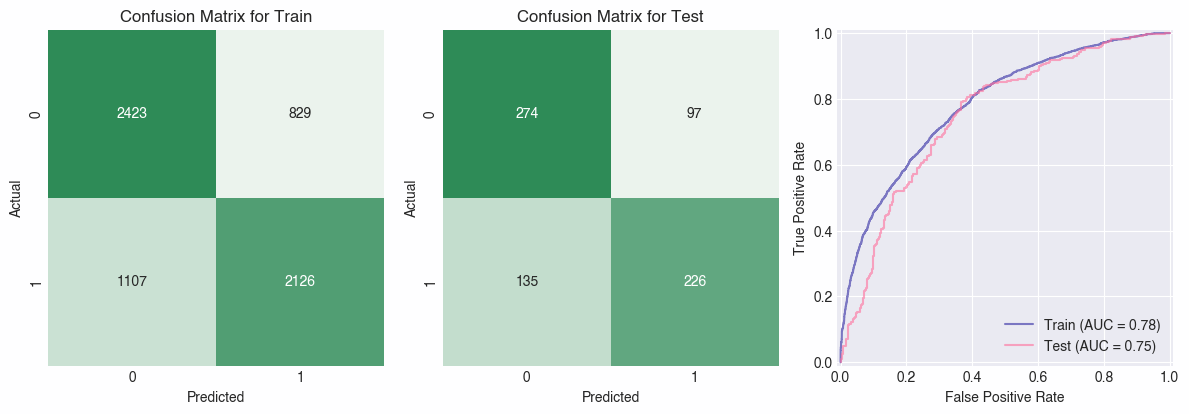

In [34]:
# predict & proba
pred_test = grid_search_rf_v9.predict(X_test)
proba_test = grid_search_rf_v9.predict_proba(X_test)

pred_train = grid_search_rf_v9.predict(X_train)
proba_train = grid_search_rf_v9.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [35]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v9)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=26,
                                        min_samples_split=33,
                                        n_estimators=300))])

 ----- best parameter: -----
{'classifier__max_depth': 6,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 26,
 'classifier__min_samples_split': 33,
 'classifier__n_estimators': 300}

 ----- RandomForestClassifier -----
   has on average 83 nodes
   has on average a maximum depth of 6

